### AudioSignalProcessing
- Примеры извлечения фич из аудио сигнала (mfcc и пр.)
- Примеры сетей разного типа (CNN, RNN, перцептрон и пр.) для распознования аудио сигнала на тестовых данных
- Подготовить модель распознавания ключевых фраз + other

In [2]:
from os.path import join, isdir, isfile
import os
import shutil
from tqdm.auto import tqdm
import librosa
import IPython.display as ipd
import pandas as pd
from pandas import DataFrame, Series
import json
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
import soundcard as sc
import python_speech_features
import tensorflow as tf
from sklearn.model_selection import train_test_split
from importlib import reload
from time import sleep

import audio_signal_processing as asp

In [112]:
#######################################################################################
# Define variables here
#######################################################################################

downloads = r'.\VoiceSamples'

# Используется в 'Prepare voice samples folder'
origin_voice_samples_folders = join(downloads, 'speech_commands_v0.01')

# HappyOthers10Samples HappyAutoGenerated, YesNoFive10Samples,
# OnOffUpDownStopOthers250Samples, OnOffUpDownStopOthers250SamplesCleaned, DummySamples
voice_samples_folder = r'ListenCompOthers'

input_voice_samples_folders = join(downloads, voice_samples_folder)

output_voice_features_json = join(input_voice_samples_folders, "data.json")
output_trained_model = join(input_voice_samples_folders, "model.h5")

threshold = 0.05 # Threshold to remove silence

sample_length = 8000 # 1 sec. of audio
sample_rate = 8000

#######################################################################################

#######################################################################################

In [115]:
reload(asp)

<module 'audio_signal_processing' from 'C:\\Users\\balob\\Documents\\AudioSignalProcessing\\audio_signal_processing.py'>

### Подготовка данных и сохранение в файл

In [102]:
# Используются записи ключевых слов длительностью 1 секунда,
# сложенные в дирректории, названные в соответствии со словами, содержащимися в них.

# На выходе получаем следующие данные:
# {
#     'mapping':['five', 'no', 'yes',...],
#     'labels':[0,0,0,... 1,1,1,... 2,2,2,...],
#     'MFCCs':[no_of_sample, time_steps, mfcc_koefficient],
#     'files':['.\\VoiceSamples\\YesNoFive10Samples\\five\\004ae714_nohash_0.wav',...]
# }

asp.preprocess_dataset(input_voice_samples_folders, output_voice_features_json,
                       sample_length=sample_length, sample_rate=sample_rate)

print('\nCompleted')

# На основе:
# The Sound of AI, Deep Learning (Audio) Application: From Design to Deployment, Preparing the Speech Dataset,
# https://www.youtube.com/watch?v=VPJ2jazh_KI&list=PL-wATfeyAMNpCRQkKgtOZU_ykXc63oyzp&index=2
# GitHub с кодом:
# https://github.com/musikalkemist/Deep-Learning-Audio-Application-From-Design-to-Deployment/tree/master/2-%20Preparing%20the%20Dataset


Processing: 'ListenComp'




Processing: 'others'




Completed


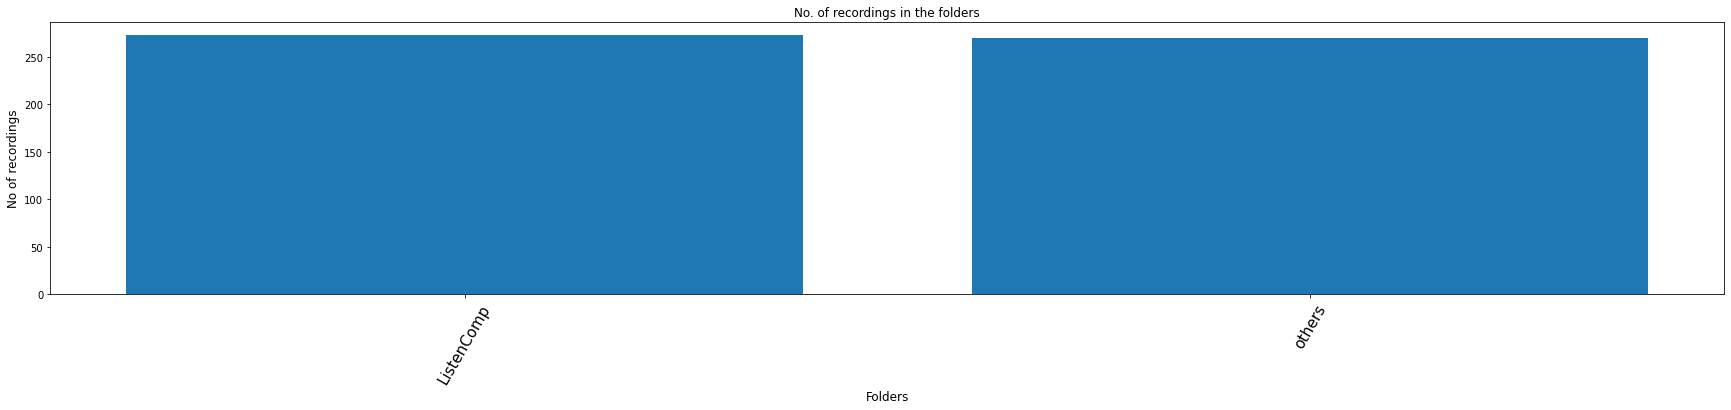

In [103]:
# Проверить кол-во аудиосэмплов каждой фразы

# Folder names with audio samples
labels = [folder for folder in os.listdir(input_voice_samples_folders) 
          if isdir(join(input_voice_samples_folders, folder))]

# Find count of each label and plot bar graph
no_of_recordings=[]
for label in labels:
    waves = [file for file in os.listdir(join(input_voice_samples_folders, label)) if file.endswith('.wav')]
    no_of_recordings.append(len(waves))
    
# Plot
plt.figure(figsize=(30,5))
index = np.arange(len(labels))
plt.bar(index, no_of_recordings)
plt.xlabel('Folders', fontsize=12)
plt.ylabel('No of recordings', fontsize=12)
plt.xticks(index, labels, fontsize=15, rotation=60)
plt.title('No. of recordings in the folders')
plt.show()

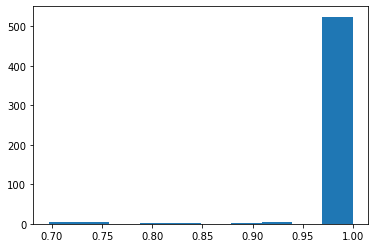

In [104]:
# Проверить длительность сэмплов (в секундах)

duration_of_recordings=[]

for label in labels:
    waves = [file for file in os.listdir(join(input_voice_samples_folders, label)) if file.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(join(input_voice_samples_folders, label, wav))
        duration_of_recordings.append(float(len(samples)/sample_rate))  
plt.hist(np.array(duration_of_recordings))

plt.show()

### Извлечение фич из аудио сигнала (примеры)

In [5]:
#######################################################################################
# Define variables here
#######################################################################################

sample_file_path = join(downloads, 'SimpleSamples/bird.wav')

#######################################################################################

#######################################################################################

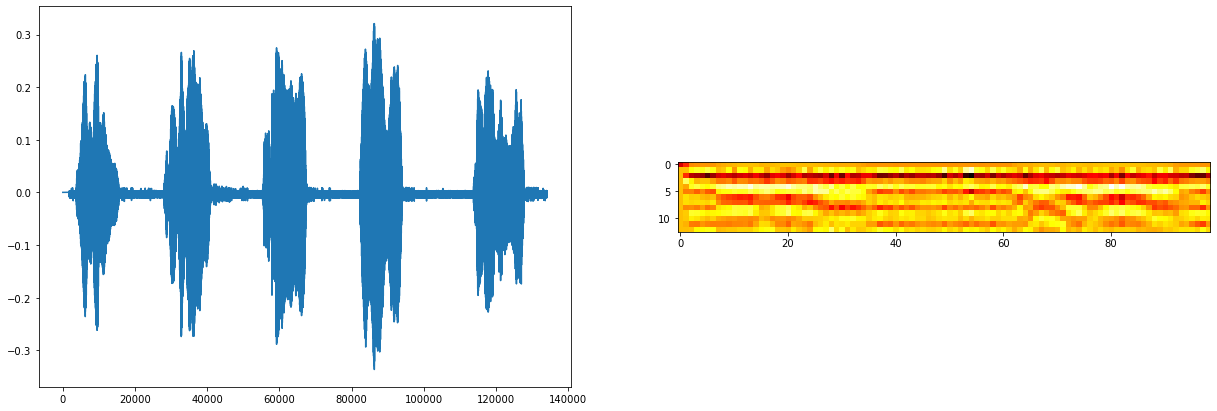

(13, 99)

In [6]:
# Извлечение mfcc с использованием python_speech_features

signal, rate = librosa.load(sample_file_path, sr=44100)

mfcc = python_speech_features.mfcc(signal[:rate], rate, numcep=13, nfilt=13, nfft=1103).T

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(21, 7))
axes[0].plot(signal)
axes[1].imshow(mfcc, cmap='hot', interpolation='nearest')
plt.show()

mfcc.shape # (13, 44)

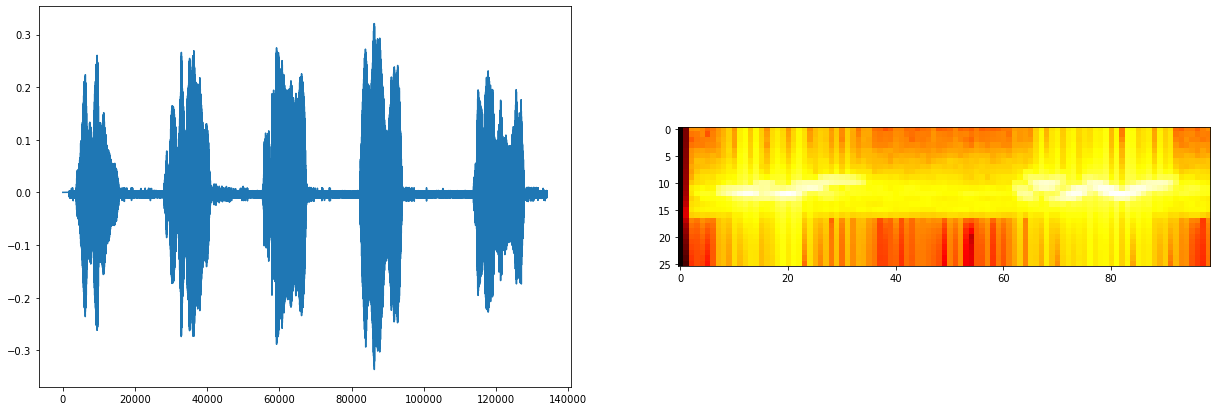

(26, 99)

In [7]:
# Извлечение logfbank с использованием python_speech_features

signal, rate = librosa.load(sample_file_path, sr=44100)

logfbank = python_speech_features.logfbank(signal[:rate], rate, nfilt=26, nfft=1103).T

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(21, 7))
axes[0].plot(signal)
axes[1].imshow(logfbank, cmap='hot', interpolation='nearest')
plt.show()

logfbank.shape # (13, 44)

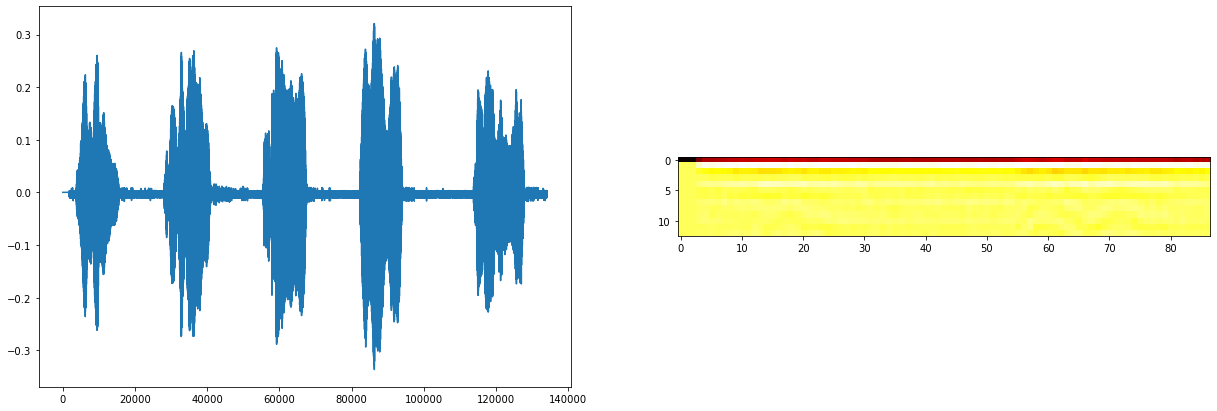

(13, 87)

In [8]:
# Извлечение mfcc в nm.array из wav файла с использованием librosa (ИСПОЛЬЗОВАТЬ)

signal, rate = librosa.load(sample_file_path, sr=44100)

# extract MFCCs
mfcc = librosa.feature.mfcc(signal[:rate], sr=rate, n_mfcc=13, n_fft=1103, hop_length=512)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(21, 7))
axes[0].plot(signal)
axes[1].imshow(mfcc, cmap='hot', interpolation='nearest')
plt.show()

mfcc.shape

### Пример применения CNN

In [7]:
# Загрузка данных и подготовка переменных

X_real, y_real, mapping = asp.load_data(output_voice_features_json)

#######################################################################################
# Define variables here
#######################################################################################

samples_in_class = 250 # определяется для генерации данных вручную
classes = len(mapping)

EPOCHS = 100
BATCH_SIZE = 32
PATIENCE = 5
LEARNING_RATE = 0.0001

#######################################################################################

#######################################################################################

##### Применение CNN Conv2D на dummy
Пример решения задачи классификации с использованием tensorflow CNN. Данные сгенерированы вручную аналогичные данным голоса mfcc.


    X_train:      (960, 44, 13, 1)
    X_validation: (240, 44, 13, 1)
    X_test:       (300, 44, 13, 1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 42, 11, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 42, 11, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 21, 6, 64)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 19, 4, 32)         18464     
_________________________________________________________________
batch_normalization_1 (Batch (None, 19, 4, 32)         128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 2, 32)         0         
_______________

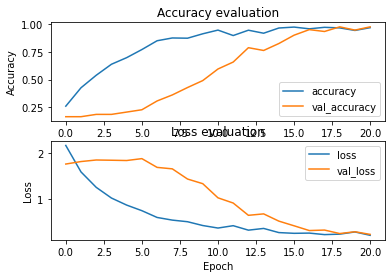

300/300 [==============================] - 0s 183us/sample - loss: 0.2439 - accuracy: 0.9633


In [15]:
# Генерация данных вручную, обучение модели, тестирование и сохранение осученной модели в файл

def main():
    
    # generate dataset
    X, y = asp.gen_feat(classes=classes, samples_in_class=samples_in_class, dim=3)
    
    # generate train, validation and test sets
    X_train, y_train, X_validation, y_validation, X_test, y_test = asp.prepare_dataset(X, y)

    print(f"""
    X_train: {str(X_train.shape):>21}
    X_validation: {str(X_validation.shape):>15}
    X_test: {str(X_test.shape):>22}\n""")
    
    # create network
    input_shape = (X_train.shape[1], X_train.shape[2], 1) # (segments, coeffisients=13, 1)
    model = asp.build_model_conv2d(input_shape, classes, learning_rate=LEARNING_RATE)
    
    # train network
    history = asp.train(model, EPOCHS, BATCH_SIZE, PATIENCE, X_train, y_train, X_validation, y_validation)
    
    # plot accuracy / loss for training/validation set as a function of the epochs
    asp.plot_history(history)
    
    # evaluate network on test set
    test_loss, test_acc = model.evaluate(X_test, y_test)
    
    # save model
    model.save(output_trained_model)

main()

##### Применение CNN Conv2D на реальных данных
Пример решения задачи классификации с использованием tensorflow CNN. Данные сгенерированы вручную аналогичные данным голоса mfcc.


    X_train:      (347, 16, 13, 1)
    X_validation: (87, 16, 13, 1)
    X_test:       (109, 16, 13, 1)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 14, 11, 64)        640       
_________________________________________________________________
batch_normalization_6 (Batch (None, 14, 11, 64)        256       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 7, 6, 64)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 5, 4, 32)          18464     
_________________________________________________________________
batch_normalization_7 (Batch (None, 5, 4, 32)          128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 3, 2, 32)          0         
______________

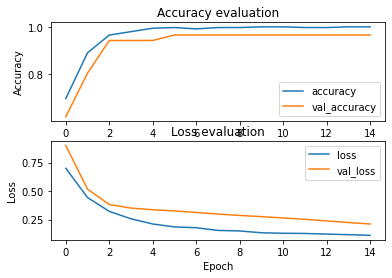

109/109 [==============================] - 0s 128us/sample - loss: 0.2057 - accuracy: 0.9817


In [105]:
# Обучение модели на реальных данных, тестирование и сохранение обученной модели в файл

def main():
    
    # generate train, validation and test sets
    X_train, y_train, X_validation, y_validation, X_test, y_test = asp.prepare_dataset(X_real, y_real)

    print(f"""
    X_train: {str(X_train.shape):>21}
    X_validation: {str(X_validation.shape):>15}
    X_test: {str(X_test.shape):>22}\n""")
    
    # create network
    input_shape = (X_train.shape[1], X_train.shape[2], 1) # (segments, coeffisients=13, 1)
    model = asp.build_model_conv2d(input_shape, classes, learning_rate=LEARNING_RATE)
    
    # train network
    history = asp.train(model, EPOCHS, BATCH_SIZE, PATIENCE, X_train, y_train, X_validation, y_validation)
    
    # plot accuracy/loss for training/validation set as a function of the epochs
    asp.plot_history(history)
    
    # evaluate network on test set
    test_loss, test_acc = model.evaluate(X_test, y_test)
    
    # save model
    model.save(output_trained_model)

main()

##### Проверка для сгенерированных вручную данных

In [16]:
# Загрузка модели и проверка на повторно сгенерированных данных (для сгенерированных вручную данных)

# Поготовить новые данные
X, y = asp.gen_feat(classes=classes, samples_in_class=samples_in_class, dim=3)
X_train, y_train, X_validation, y_validation, X_test, y_test = asp.prepare_dataset(X, y)

# Загрузить модель из файла
model = tf.keras.models.load_model(output_trained_model)
model.summary()

# Протестировать модель на новых данных
test_loss, test_acc = model.evaluate(X_train, y_train)
print(f"\nTest loss: {round(test_loss, 3)}\nTest accuracy: {round(100*test_acc,2)}%")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 42, 11, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 42, 11, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 21, 6, 64)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 19, 4, 32)         18464     
_________________________________________________________________
batch_normalization_1 (Batch (None, 19, 4, 32)         128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 2, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 1, 32)          4

In [11]:
# Тестирование на отдельных данных для сгенерированных вручную данных

index = 11

result = model.predict(X_train)

predicted_result_ind = np.argmax(result[index])
result_ind = y_train[index]

print(f'Predicted: {predicted_result_ind}, Fact: {result_ind}')

NameError: name 'X_train' is not defined

##### Проверка для данных с микрофона или из файла

In [106]:
# Загрузить модель из файла
model = tf.keras.models.load_model(output_trained_model)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 14, 11, 64)        640       
_________________________________________________________________
batch_normalization_6 (Batch (None, 14, 11, 64)        256       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 7, 6, 64)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 5, 4, 32)          18464     
_________________________________________________________________
batch_normalization_7 (Batch (None, 5, 4, 32)          128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 3, 2, 32)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 2, 1, 32)         

In [99]:
# Предсказание с микрофона (для обученной на реальных данных модели)

samplerate = 8000 # (int) – The desired sampling rate in Hz
sec = 1

numframes = int(samplerate * sec) # (int) – The number of frames to record. Такой же как samplerate, чтобы записать секунду.
default_mic = sc.default_microphone()

# Загрузить модель из файла
model = tf.keras.models.load_model(output_trained_model)

mapping

['happy', 'others']

In [100]:
# Тестирование на микрофоне

print(f'Microphone in use: {default_mic}')
signal = default_mic.record(samplerate = samplerate, numframes = numframes, channels = 1).ravel()

# Предобработка сигнала при использовании фильтрации тишины
# mask = remove_silence(signal, sample_length, threshold)
# sample_filtered = signal[mask]
# # Вернуть к исходному sample_rate
# signal = librosa.resample(sample_filtered, len(sample_filtered), sample_length)

if len(signal) >= sample_length:
    # ensure consistency of the length of the signal
    signal = signal[:sample_length]
    # extract MFCCs
    mfcc = librosa.feature.mfcc(signal, sample_rate, n_mfcc=13, n_fft=2048, hop_length=512)
    # store data for analysed track
    mfcc = mfcc.T[np.newaxis,..., np.newaxis]
    
result = model.predict(mfcc)
predicted_result_ind = np.argmax(result)

print(f'Predicted: {mapping[predicted_result_ind]}')

Microphone in use: <Microphone Микрофон гарнитуры (Plantronics C320-M) (2 channels)>
Predicted: happy


In [113]:
# Тестирование на файле
# sample_length=sample_length, sample_rate=sample_rate

origin_filename = 'ListenComp\\ListenComp00_noice11.wav'
sample, _ = librosa.load(join(input_voice_samples_folders, origin_filename), sr=sample_rate) # 22050 8000

if len(sample) >= sample_length:
    # ensure consistency of the length of the signal
    sample = sample[:sample_length]
    # extract MFCCs
    mfcc = librosa.feature.mfcc(sample, sample_rate, n_mfcc=13, n_fft=2048, hop_length=512)
    # store data for analysed track
    mfcc = mfcc.T[np.newaxis,..., np.newaxis]
    print('File processing completed')
    
result = model.predict(mfcc)
predicted_result_ind = np.argmax(result)

print(f'Predicted: {mapping[predicted_result_ind]}, {result}')

File processing completed
Predicted: others, [[0.33787364 0.66212636]]


In [87]:
sample_rate

22050

In [114]:
sample_length=8000
num_mfcc=13
n_fft=2048
hop_length=512

origin_filename = 'ListenComp\\ListenComp00.wav'
signal, _ = librosa.load(join(input_voice_samples_folders, origin_filename))
if len(signal) >= sample_length:
    # ensure consistency of the length of the signal
    signal = signal[:sample_length]
    # extract MFCCs
    MFCCs = librosa.feature.mfcc(signal, sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
    mfcc = MFCCs.T[np.newaxis,..., np.newaxis]

result = model.predict(mfcc)
predicted_result_ind = np.argmax(result)

print(f'Predicted: {mapping[predicted_result_ind]}, {result}')

Predicted: ListenComp, [[0.9117517  0.08824834]]


In [73]:
X_real[0].shape

(16, 13, 1)

In [54]:
for x in zip(X_real, y_real):
    pass
print(x[0].shape, x[1])

(16, 13, 1) 1


In [60]:
for x, y in zip(X_real[:10], y_real[:10]):
    mfcc = x[np.newaxis,...]
    result = model.predict(mfcc)
    predicted_result_ind = np.argmax(result)
    print(f'Predicted: {predicted_result_ind}; Result: {y}; {result}')

Predicted: 0; Result: 0; [[0.94939923 0.05060076]]
Predicted: 0; Result: 0; [[0.9094222  0.09057774]]
Predicted: 0; Result: 0; [[0.9170604  0.08293966]]
Predicted: 0; Result: 0; [[0.9056914  0.09430862]]
Predicted: 0; Result: 0; [[0.9279169  0.07208313]]
Predicted: 0; Result: 0; [[0.906716   0.09328404]]
Predicted: 0; Result: 0; [[0.9047743  0.09522567]]
Predicted: 0; Result: 0; [[0.9134355 0.0865645]]
Predicted: 0; Result: 0; [[0.90972805 0.09027196]]
Predicted: 0; Result: 0; [[0.9140799  0.08592007]]


In [19]:
test_loss, test_acc = model.evaluate(X_real, y_real)

543/543 [==============================] - 0s 332us/sample - loss: 0.3130 - accuracy: 0.9116


Shape: (8000,)


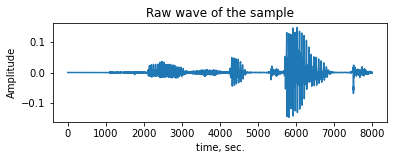

Shape: (8000,)


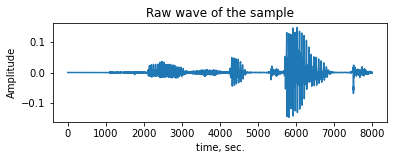

In [18]:
asp.two_samples_analyzer(sample, sample)

### Пример применения MLP
На основе:
- The Sound of AI, 9- How to implement a (simple) neural network with TensorFlow 2, https://www.youtube.com/watch?v=JdXxaZcQer8&list=PL-wATfeyAMNrtbkCNsLcpoAyBBRJZVlnf&index=9


    X_train:           (480, 8000)
    X_validation:     (120, 8000)
    X_test:            (150, 8000)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 5)                 40005     
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 6         
Total params: 40,011
Trainable params: 40,011
Non-trainable params: 0
_________________________________________________________________
Train on 480 samples, validate on 120 samples
Epoch 1/100
480/480 [==============================] - 0s 618us/sample - loss: 0.8254 - accuracy: 0.3729 - val_loss: 0.7265 - val_accuracy: 0.3333
Epoch 2/100
480/480 [==============================] - 0s 129us/sample - loss: 0.7729 - accuracy: 0.3896 - val_loss: 0.6929 - val_accuracy: 0.3583
Epoch 3/100
480/480 [==============================] - 0s 156us/sa

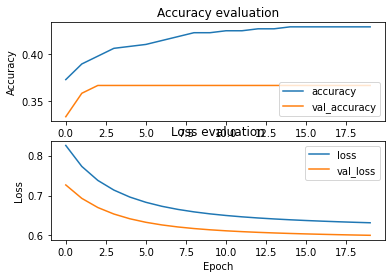

In [48]:
# Генерация данных, обучение модели, тестирование и сохранение обученной модели в файл

def main():
    
    # generate dataset
    X, y = asp.gen_feat(classes=classes, samples_in_class=samples_in_class, dim=1)
    
    # generate train, validation and test sets
    X_train, y_train, X_validation, y_validation, X_test, y_test = asp.prepare_dataset(X, y)

    print(f"""
    X_train: {str(X_train.shape):>21}
    X_validation: {str(X_validation.shape):>15}
    X_test: {str(X_test.shape):>22}\n""")
    
    # create network
    model = asp.build_model_mlp(learning_rate=LEARNING_RATE)
    
    history = asp.train(model, EPOCHS, BATCH_SIZE, PATIENCE, X_train, y_train, X_validation, y_validation)
    
    # evaluate model on test set
    print("\nEvaluation on the test set:")
    model.evaluate(X_test,  y_test, verbose=2)
    
    # plot accuracy/loss for training/validation set as a function of the epochs
    asp.plot_history(history)
    
    # save model
    model.save(output_trained_model)

main()

### Prepare voice samples folder

In [3]:
# Prepare voice samples folder

num_samples_to_copy = 250
num_samples_to_copy_others = 9

# Read all folders
folders = [folder for folder in os.listdir(origin_voice_samples_folders) if isdir(join(origin_voice_samples_folders, folder))]

# Select folders for classification and others
class_folders = ['On', 'Off', 'Up', 'Down', 'Stop']
other_folders = [folder for folder in folders if not folder in class_folders and not folder.startswith('_')]

# Create new folders for classification + others
os.makedirs(input_voice_samples_folders, exist_ok=True, mode=777)
os.makedirs(join(input_voice_samples_folders, 'others'), exist_ok=True, mode=777)
for class_folder in class_folders:
    os.makedirs(join(input_voice_samples_folders, class_folder), exist_ok=True, mode=777)

# Copy files to folders for classification
for class_folder in tqdm(class_folders):
    files = [file for file in os.listdir(join(origin_voice_samples_folders, class_folder))
             if isfile(join(origin_voice_samples_folders, class_folder, file))]
    for file in files[:num_samples_to_copy]:
        shutil.copy(join(origin_voice_samples_folders, class_folder, file),
                    join(input_voice_samples_folders, class_folder))

# Copy files to others for classification
for class_folder in tqdm(other_folders):
    files = [file for file in os.listdir(join(origin_voice_samples_folders, class_folder))
             if isfile(join(origin_voice_samples_folders, class_folder, file))]
    for file in files[:num_samples_to_copy_others]:
        shutil.copy(join(origin_voice_samples_folders, class_folder, file),
                    join(input_voice_samples_folders, 'others', f'{class_folder}_{file}'))

### Multiply the original samples in the folder

In [ ]:
# Записать сэмплы с микрофона

num_samples = 3
file_preffix = 'ListenComp'
sample_rate = 8000 # (int) – The desired sampling rate in Hz
sec = 1

numframes = int(sample_rate * sec) # (int) – The number of frames to record. Такой же как sample_rate, чтобы записать секунду.

default_mic = sc.default_microphone()

print(f'Microphone in use: {default_mic}')

# Записать файл с микрофона, Сохранить файл на диск

for i in range(num_samples):
    file_name = f'{file_preffix}{i:02}.wav'
    print(f'Go for {file_name}')
    sleep(0.5)
    sample = default_mic.record(samplerate = sample_rate, numframes=numframes, channels=1).ravel()
    librosa.output.write_wav(path=join(input_voice_samples_folders, file_name), y=sample, sr=sample_rate)
    print(f'{file_name} done')
    sleep(1)
print('All done')

In [44]:
# Размножить оригинальные сэмплы путем добавления шумов, удаления тишини и удаления части данных

sample_rate = 8000
sec = 1

numframes = int(sample_rate * sec)

multiplier = 30 # times of reprocessing the original file by each reprocessor

noice_vol_min = 0.05
noice_vol_max = 0.1

silence_thr_min = 0.01
silence_thr_max = 0.1

rem_coef_min = 0.05
rem_coef_max = 0.2

# Add noice

def multiply_sample_noice(sample, sr=8000, nframes=8000):
    file_suffix = 'noice'
    for i, noice_vol in enumerate(np.random.uniform(noice_vol_min, noice_vol_max, multiplier)):
        sample_filtered = asp.add_noice(sample, nframes=nframes, noice_vol=noice_vol)
        output_filename = f'{origin_filename[:-4]}_{file_suffix}{i:02}.wav'
        librosa.output.write_wav(path=join(input_voice_samples_folders, output_filename), y=sample_filtered, sr=sr)
        
# Фильтрация тишины

def multiply_sample_filter_silence(sample, sr=8000):
    file_suffix = 'silence'
    for i, silence_thr in enumerate(np.random.uniform(silence_thr_min, silence_thr_max, multiplier)):
        sample_filtered, sr_filtered = asp.remove_silence(sample, sr=sr, threshold=silence_thr)
        sample_filtered = librosa.resample(sample_filtered, orig_sr=sr_filtered, target_sr=sr)[:sr]
        output_filename = f'{origin_filename[:-4]}_{file_suffix}{i:02}.wav'
        librosa.output.write_wav(path=join(input_voice_samples_folders, output_filename), y=sample_filtered, sr=sr)
        
# Удаление части данных

def multiply_sample_spoil_audio(sample, sr=8000):
    file_suffix = 'spoiled'
    for i, rem_coef in enumerate(np.random.uniform(rem_coef_min, rem_coef_max, multiplier)):
        sample_filtered = asp.spoil_audio(sample, sr=sr, rem_coef=rem_coef)
        output_filename = f'{origin_filename[:-4]}_{file_suffix}{i:02}.wav'
        librosa.output.write_wav(path=join(input_voice_samples_folders, output_filename), y=sample_filtered, sr=sr)
        
for i, (dirpath, dirnames, filenames) in enumerate(os.walk(input_voice_samples_folders)):
    for filename in filenames:
        if filename[-3:] == 'wav':
            origin_filename = filename
            sample, sample_rate = librosa.load(join(input_voice_samples_folders, origin_filename), sr=8000)
            multiply_sample_noice(sample, sr=sample_rate, nframes=numframes)
            multiply_sample_filter_silence(sample, sr=sample_rate)
            multiply_sample_spoil_audio(sample, sr=sample_rate)

### Remove silence from voice samples

In [6]:
# Remove silence from the prepared voice samples folders

# Показала неэффективность. Возможно, из-за сильного искажения исходнях данных

# Проверка на данных: OnOffUpDownStopOthers250Samples / OnOffUpDownStopOthers250SamplesCleaned
# threshold = 0.3 # Threshold to remove silence

# Результаты на исходных данных
# loss: 0.1640 - accuracy: 0.9942 - val_loss: 0.5803 - val_accuracy: 0.8131

# Результаты на отфильтрованных данных
# loss: 0.3894 - accuracy: 0.9208 - val_loss: 1.1525 - val_accuracy: 0.6230

# Вывод: данная предобработка значительно ухудшила результаты

def remove_silence(sample, sample_rate, threshold):
    '''Remove values less then defined threshold. Threshold is defined between 0 and 1.
    Moving average is used to prepare the sample for analysis.'''
    mask = []
    sample = pd.Series(sample).apply(np.abs)
    sample_mean = sample.rolling(window=int(sample_rate/10), min_periods=1, center=True).mean()
    threshold = sample_mean.max() * threshold
    for mean in sample_mean:
        if mean > threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask

# mask = remove_silence(signal, sample_length, threshold)
# sample_filtered = signal[mask]
# # Вернуть к исходному sample_rate
# sample_filtered = librosa.resample(sample_filtered, len(signal[mask]), sample_length)

def remove_silence_dataset(dataset_path, sample_length=22050):
    """Extracts MFCCs from music dataset and saves them into a json file.
    :param dataset_path (str): Path to dataset
    :param json_path (str): Path to json file used to save MFCCs
    :param num_mfcc (int): Number of coefficients to extract
    :param n_fft (int): Interval we consider to apply FFT. Measured in # of samples
    :param hop_length (int): Sliding window for FFT. Measured in # of samples
    :param sample_length (int): Audio sample length
    :return:
    """
    # loop through all sub-dirs
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        # ensure we're at sub-folder level
        if dirpath is not dataset_path:
            # save label (i.e., sub-folder name) in the mapping
            label = dirpath.split("\\")[-1]
            print("\nProcessing: '{}'".format(label))
            
            # process all audio files in sub-dir and store MFCCs
            for file in tqdm(filenames):
                file_path = join(dirpath, file)
                # load audio file and slice it to ensure length consistency among different files
                signal, sample_rate = librosa.load(file_path)
                # drop audio files with less than pre-decided number of samples
                if len(signal) >= sample_length:
                    # ensure consistency of the length of the signal
                    signal = signal[:sample_length]
                elif len(signal) < sample_length:
                    signal = librosa.resample(signal, len(signal), sample_length)
                    
                mask = remove_silence(signal, sample_length, threshold)
                sample_filtered = signal[mask]

                # Вернуть к исходному sample_rate
                sample_filtered = librosa.resample(sample_filtered, len(signal[mask]), sample_length)

                # Сохранить переработанный файл
                librosa.output.write_wav(path=file_path, y=sample_filtered, sr=sample_length)
                
remove_silence_dataset(input_voice_samples_folders, sample_length=22050)


Processing: 'Down'




Processing: 'Off'




Processing: 'On'




Processing: 'others'




Processing: 'Stop'




Processing: 'Up'


### Материал
- Seth Adams, Deep Learning for Audio Classification, https://www.youtube.com/playlist?list=PLhA3b2k8R3t2Ng1WW_7MiXeh1pfQJQi_P
- Mel Frequency Cepstral Coefficient (MFCC) tutorial, http://www.practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/
- sentdex, Neural Networks from Scratch in Python, https://www.youtube.com/playlist?list=PLQVvvaa0QuDcjD5BAw2DxE6OF2tius3V3
- The Sound of AI, Deep Learning (Audio) Application: From Design to Deployment, https://www.youtube.com/playlist?list=PL-wATfeyAMNpCRQkKgtOZU_ykXc63oyzp <br>**Переработано**: "Deploying the Speech Recognition System with uWSGI"
- The Sound of AI, Deep Learning (for Audio) with Python, https://www.youtube.com/playlist?list=PL-wATfeyAMNrtbkCNsLcpoAyBBRJZVlnf
<br>Done: 9- How to implement a (simple) neural network with TensorFlow 2

##### Датасеты с наборами слов
1. Google AI Blog, Speech Commands Dataset<br>
"The dataset has 65,000 one-second long utterances of 30 short words, by thousands of different people, contributed by members of the public through the AIY website."<br>
https://ai.googleblog.com/2017/08/launching-speech-commands-dataset.html

### Developments

In [ ]:
# 1. Доработать функцию фильтрации тишины и вынести в библиотеку
# 2. Функцию ухудшения качества вынести в библиотеку
# Размножение сэмплов:
# 1. Сделать размножитель аудиосэмплов
# а. Добавить частоты
# б. Добавить шум
# в. Растянуть
# г. Сжать

In [61]:
# Чтение файла

# origin_filename = join('happy', 'HappyOrigin01.wav')
origin_filename = 'HappyOrigin01.wav'
sample, sample_rate = librosa.load(join(input_voice_samples_folders, origin_filename), sr=8000)
# sample, sample_rate = librosa.load(join(input_voice_samples_folders, origin_filename)) # Def. sr=22050 in sec

In [4]:
# Преобразование

sample = librosa.resample(sample, orig_sr=sample_rate, target_sr=8000)

In [62]:
# Сохранение файла

librosa.output.write_wav(path=join(input_voice_samples_folders, 'Happy001.wav'), y=sample, sr=sample_rate)

Shape: (8000,)


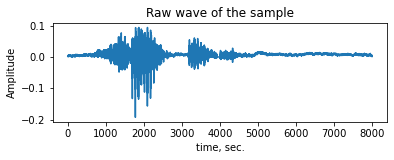

Shape: (8000,)


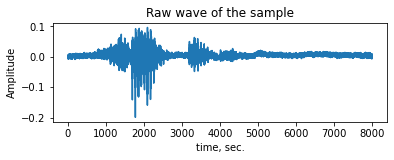

In [65]:
# Add noice

sample_filtered = asp.add_noice(sample, sr=8000, noice_vol=0.05)
asp.two_samples_analyzer(sample, sample_filtered)

Shape: (8000,)


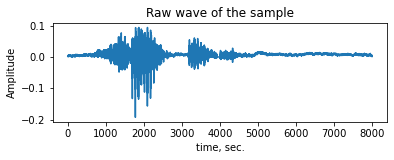

Shape: (8000,)


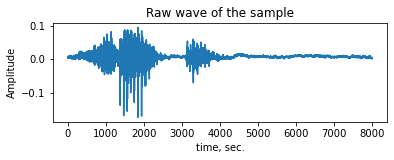

6789

In [40]:
# Фильтрация тишины

target_sr = 8000
sample_filtered, sr_filtered = asp.remove_silence(sample, sr=target_sr, threshold=0.25)
sample_filtered = librosa.resample(sample_filtered, orig_sr=sr_filtered, target_sr=target_sr)[:target_sr]
asp.two_samples_analyzer(sample, sample_filtered)

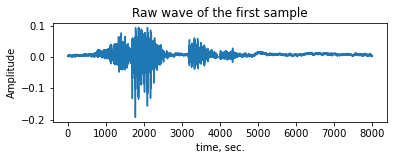

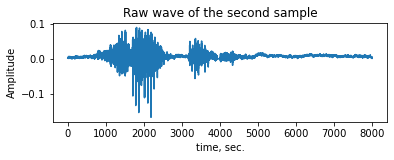

In [16]:
# Удаление части данных

sample_filtered = asp.spoil_audio(sample, sr=8000, rem_coef=0.1)
asp.two_samples_analyzer(sample, sample_filtered)

In [41]:
num_samples = 3
file_preffix = 'ListenComp'
sample_rate = 8000 # (int) – The desired sampling rate in Hz
sec = 1

numframes = int(sample_rate * sec) # (int) – The number of frames to record. Такой же как sample_rate, чтобы записать секунду.

default_mic = sc.default_microphone()

print(f'Microphone in use: {default_mic}')

# Записать файл с микрофона, Сохранить файл на диск

for i in range(num_samples):
    file_name = f'{file_preffix}{i:02}.wav'
    print(f'Go for {file_name}')
    sleep(0.5)
    sample = default_mic.record(samplerate = sample_rate, numframes=numframes, channels=1).ravel()
    librosa.output.write_wav(path=join(input_voice_samples_folders, file_name), y=sample, sr=sample_rate)
    print(f'{file_name} done')
    sleep(1)
print('All done')

Microphone in use: <Microphone Микрофон гарнитуры (Plantronics C320-M) (2 channels)>
Go for ListenComp00.wav
ListenComp00.wav done
Go for ListenComp01.wav
ListenComp01.wav done
Go for ListenComp02.wav
ListenComp02.wav done
All done


Shape: (8000,)


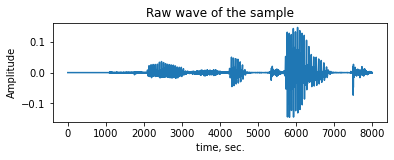

Shape: (8000,)


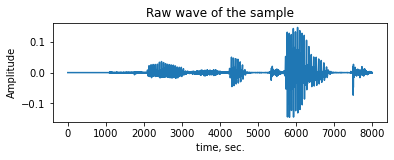

In [42]:
asp.two_samples_analyzer(sample, sample, sr=samplerate)